# Install packages

In [1]:
!pip install optuna
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.7 MB/s eta 0:00:00


# Imports

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import yfinance
from torchvision.transforms import transforms
import time
import os
import optuna
from sklearn.preprocessing import MinMaxScaler

# Hyperparameter optimization
Hyperparameter optimization in machine learning refers to the process of finding the optimal set of hyperparameters for a given model to achieve the best performance on a specific dataset. Hyperparameters are parameters that are set before the learning process begins, such as the learning rate, number of hidden layers, or regularization strength. Unlike model parameters, which are learned during training, hyperparameters are typically tuned through methods like grid search, random search, or more advanced techniques like Bayesian optimization or genetic algorithms. Proper hyperparameter tuning is crucial for maximizing a model's performance and generalization ability, ultimately leading to better predictive accuracy and robustness in real-world applications.

**Content**
- Minimization of functions with Optuna
- Hyperparameter Tuning with Optuna

## The Optuna framework for Bayesian Optimization
Bayesian optimization (BO) is a powerful technique for hyperparameter search, aiming to find the optimal set of hyperparameters with minimal computational resources. One popular Python framework for implementing Bayesian optimization is [Optuna](https://optuna.org). Leveraging probabilistic models, Bayesian optimization iteratively selects hyperparameters based on their potential to improve the model's performance, guided by past evaluations. Optuna offers a user-friendly interface for defining parameter spaces, specifying objectives, and running the optimization process efficiently. By intelligently exploring the hyperparameter space, Optuna enables practitioners to fine-tune machine learning models effectively.

Optuna, at its core uses Bayesian optimization to find maxima or minima of functions. Here we find the minumum of a simple 2D quadratic function.

In [3]:
# A simple quadratic functionm. Its minimum is at (1,3).
def quadratic_function(p):
 # p = dictionary of parameters
 return (p['x1'] + 2.*p['x2'] - 7)**2. + (2.*p['x1'] + p['x2'] - 5.)**2.

In [4]:
# We here use Optuna to optimize the quadratic function.
def objective(trial):
    # Define the search space
    x1 = trial.suggest_float('x1', -10, 10)
    x2 = trial.suggest_float('x2', -10, 10)
    # Evaluate the objective function
    return quadratic_function({'x1': x1, 'x2': x2})
# Create a study object
study = optuna.create_study(direction='minimize', study_name='quadratic_function')
# Optimize the objective function
study.optimize(objective, n_trials=100, n_jobs=10)

[I 2025-05-24 18:09:09,853] A new study created in memory with name: quadratic_function
[I 2025-05-24 18:09:09,857] Trial 0 finished with value: 299.83383836048915 and parameters: {'x1': 6.840990538710706, 'x2': 5.2326102583542635}. Best is trial 0 with value: 299.83383836048915.
[I 2025-05-24 18:09:09,858] Trial 1 finished with value: 483.6063005159707 and parameters: {'x1': 7.07317515918994, 'x2': 7.276185689993717}. Best is trial 0 with value: 299.83383836048915.
[I 2025-05-24 18:09:09,861] Trial 2 finished with value: 749.4976336437383 and parameters: {'x1': -1.587006678925194, 'x2': -7.074948557612988}. Best is trial 0 with value: 299.83383836048915.
[I 2025-05-24 18:09:09,862] Trial 3 finished with value: 606.1575397953286 and parameters: {'x1': -2.6141098150638857, 'x2': -4.903584247568364}. Best is trial 0 with value: 299.83383836048915.
[I 2025-05-24 18:09:09,863] Trial 4 finished with value: 60.31911141777516 and parameters: {'x1': -4.783579686918705, 'x2': 7.774838224959325}

In [5]:
# Finally we can print the best parameters that optuna has found. These should be close to (1,3).
print("Best parameters: ", study.best_params)

Best parameters:  {'x1': 1.1474782946126885, 'x2': 2.8845889830358944}


In [6]:
# We can also look at the the estimated function and its uncertainty as well as the tested parameter values.
optuna.visualization.plot_contour(study, params=['x1', 'x2'])

### Tasks:
1. Explain the contour plot.

## Hyperparameter optimization with Optuna
Above we have seen a very slow method to approximate minima of functions. The reason it is slow, is that it takes some time to compute a good next candidate set of parameters. This is of course less problematic, if evaluating the function takes long. We therefore often use BO for hyperparameter tuning, where evaluating the function means to train and test a neural network.

Note that this code may run very long, given limited compute resources. You might want to reduce the number of epochs and the number of trial runs.

In [7]:
# Data Setup of the Cifar10 Dataset.
working_dir = os.getcwd()
def get_dataloaders_cifar10(data_dir='./data', batch_size=512):
    DOWNLOAD = not os.path.exists(os.path.join(working_dir, "data",torchvision.datasets.CIFAR10.base_folder))
    # Transforms to put data in the right format.
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Download the CIFAR10 dataset and create data loaders.
    train_loader = torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(data_dir, train=True, download=DOWNLOAD, transform=transform),
            batch_size=batch_size,
            shuffle=True,
            pin_memory=torch.cuda.is_available(),
            num_workers=0,)
    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(data_dir, train=False, download=False, transform=transform),
        batch_size=512,
        shuffle=True,
        pin_memory=torch.cuda.is_available(),
        num_workers=0,)
    return train_loader, test_loader

In [8]:
# A simple feed-forward neural network for Cifar10 classification.
class FeedForwardModelCifar10(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.input = nn.Linear(32*32*3, config.get('hidden_size',100))
        self.output = nn.Linear(config.get('hidden_size',100), 10)

    def forward(self, x):
        x = self.input(x.flatten(1))
        x = self.output(F.mish(x))
        return x

In [9]:
# To use Optuna, we encapsulate the full model training and testing into a callable function.
# This executes epoch of training the model.
def train_epoch(model, optimizer, data_loader, device=None):
    model.train()
    for data, target in iter(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

# This returns the test accuracy of the model.
def evaluate(model, data_loader, device=None):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in iter(data_loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total

In [10]:
# This function trains and tests a configuration. We use a config dictionary for all hyperparameters.
def objective(trial):
    # Define the search space
    config = {
        'hidden_size': trial.suggest_int('hidden_size', 10, 1000),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1),
        'weight_decay': trial.suggest_float('weight_decay', 0.0, 1e-2),
        'sched_gamma': trial.suggest_float('sched_gamma', 0.5, 1.0),
        'epochs': trial.suggest_int('epochs', 1, 10),
        'batch_size': trial.suggest_int('batch_size', 32, 512)
    }

    # Create the dataloaders.
    train_loader,test_loader = get_dataloaders_cifar10(os.path.join(working_dir,'data'), config.get("batch_size"))

    # Create the model and put it on the device.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FeedForwardModelCifar10(config)
    model.to(device)

    # Create the optimizer and the scheduler.
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config.get("lr",1e-4),
        weight_decay=config.get('weight_decay',0.))

    # Train the model for a number of epochs and evaluate it.
    for i in range(config.get("epochs",20)):
        train_epoch(model, optimizer, train_loader, device=device)
        accuracy = evaluate(model, test_loader, device=device)
        # Send the current training result back to Optuna.
        trial.report(accuracy, i)
        # Handle pruning based on the intermediate value. This enables us to stop unpromising trials early.
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Return the final accuracy.
    return accuracy


In [11]:
# Create the optuna study with early stopping
study = optuna.create_study(direction="maximize", study_name="cifar10")
study.optimize(objective, n_trials=20, n_jobs=2, show_progress_bar=True, )

[I 2025-05-24 18:09:12,590] A new study created in memory with name: cifar10


  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0.00/170M [00:00<?, ?B/s]

  0%|          | 0.00/170M [00:00<?, ?B/s]
  0%|          | 65.5k/170M [00:00<05:05, 558kB/s]

  0%|          | 65.5k/170M [00:00<04:58, 571kB/s]
  0%|          | 164k/170M [00:00<03:58, 713kB/s] 

  0%|          | 229k/170M [00:00<02:46, 1.02MB/s]
  0%|          | 721k/170M [00:00<01:08, 2.48MB/s]

  1%|          | 885k/170M [00:00<00:56, 3.02MB/s]
  2%|▏         | 2.85M/170M [00:00<00:19, 8.40MB/s]

  2%|▏         | 3.01M/170M [00:00<00:17, 9.37MB/s]
  4%|▍         | 7.05M/170M [00:00<00:08, 18.9MB/s]

  4%|▍         | 6.88M/170M [00:00<00:08, 19.1MB/s]
  7%|▋         | 11.8M/170M [00:00<00:05, 27.2MB/s]

  7%|▋         | 11.8M/170M [00:00<00:05, 28.5MB/s]
  9%|▉         | 16.1M/170M [00:00<00:04, 31.9MB/s]

  9%|▉         | 16.0M/170M [00:00<00:04, 32.8MB/s]
 12%|█▏        | 20.6M/170M [00:00<00:04, 36.0MB/s]

 12%|█▏        | 20.4M/170M [00:00<00:04, 36.4MB/s]
 14%|█▍        | 24.6M/170M [00:00<00:03, 37.0MB/s]

 14%|█▍        | 24.2M/17

[I 2025-05-24 18:10:08,077] Trial 1 finished with value: 0.3576 and parameters: {'hidden_size': 507, 'lr': 0.013187836436219378, 'weight_decay': 0.0041677189848185305, 'sched_gamma': 0.6981406086433017, 'epochs': 1, 'batch_size': 234}. Best is trial 1 with value: 0.3576.
[I 2025-05-24 18:14:54,949] Trial 2 finished with value: 0.384 and parameters: {'hidden_size': 951, 'lr': 0.0074245878712444376, 'weight_decay': 0.008441533917428343, 'sched_gamma': 0.528079548927225, 'epochs': 7, 'batch_size': 500}. Best is trial 2 with value: 0.384.
[I 2025-05-24 18:14:56,202] Trial 0 finished with value: 0.2275 and parameters: {'hidden_size': 377, 'lr': 0.05749088064902155, 'weight_decay': 0.0037493989318213385, 'sched_gamma': 0.7555339060571525, 'epochs': 8, 'batch_size': 212}. Best is trial 2 with value: 0.384.
[I 2025-05-24 18:19:17,059] Trial 3 finished with value: 0.2123 and parameters: {'hidden_size': 817, 'lr': 0.07687922456292862, 'weight_decay': 0.009605017696257191, 'sched_gamma': 0.601466

In [12]:
# Best parameters and accuracy.
print("Best parameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

Best parameters:  {'hidden_size': 818, 'lr': 0.0003122244865926315, 'weight_decay': 0.0020195854894087067, 'sched_gamma': 0.5072050291093056, 'epochs': 4, 'batch_size': 327}
Best accuracy:  0.5104


In [13]:
# We can also plot feature importance.
optuna.visualization.plot_param_importances(study)

In [14]:
# Contour plot of the accuracy for the parameters lr and weight_decay.
optuna.visualization.plot_contour(study, params=['lr', 'batch_size'])

### Tasks:
1. Analyze the influence of the most important features in the contour plot.
2. Some of the trials were pruned. What does that mean?
3. What is the number of epochs in the best configuration you found? Why can it be helpful to have a lower number of training epochs?
4. What are your experiences training neural networks with hyperparameter optimization? What problems do you see when training very large models such as LLMs?

# Convolutional Neural Networks
Convolutional neural networks (CNNs) are a type of deep learning algorithm that is commonly used for image recognition and classification tasks. CNNs are inspired by the visual cortex of the human brain and are designed to automatically learn features from raw pixel data. They consist of multiple layers of neurons, including convolutional layers, pooling layers, and fully connected layers. The convolutional layers apply filters to the input image to extract features, while the pooling layers downsample the feature maps to reduce computational complexity. CNNs have been highly successful in various computer vision tasks, such as object detection, facial recognition, and image segmentation.

**Content**
- Classification of Cifar10 using a CNN
- Visualize filters
- Download pre-trained model

In [15]:
# Define the CNN model for Cifar10 classification.
class ConvNetCifar10(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=5)
        self.fc1 = nn.Linear(5*5*10, 100)
        self.fc2 = nn.Linear(100,10)

    def forward(self, x):
        x = self.conv1(x) #32x32x3->28x28x32
        x = F.mish(F.max_pool2d(x, kernel_size=2)) #28x28x32->14x14x32
        x = self.conv2(x) #14x14x32->10x10x10
        x = F.mish(F.max_pool2d(x, kernel_size=2)) #10x10x10->5x5x10
        x = x.view(-1, 5*5*10) #5x5x10->250
        x = self.fc1(x) #250->100
        x = self.fc2(F.mish(x)) #100->10
        return x

# Create the dataloaders and the model.
train_loader, test_loader = get_dataloaders_cifar10()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = ConvNetCifar10().to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

# Train the model for 10 epochs and evaluate it.
for epoch in range(10):
    train_epoch(cnn_model,optimizer,train_loader,device)
    test_acc = evaluate(cnn_model,test_loader,device)
    print(f"Epoch: {epoch}, test acc: {test_acc}")


Epoch: 0, test acc: 0.4366
Epoch: 1, test acc: 0.5129
Epoch: 2, test acc: 0.544
Epoch: 3, test acc: 0.5665
Epoch: 4, test acc: 0.5768
Epoch: 5, test acc: 0.5861
Epoch: 6, test acc: 0.6022
Epoch: 7, test acc: 0.6084
Epoch: 8, test acc: 0.6171
Epoch: 9, test acc: 0.6226


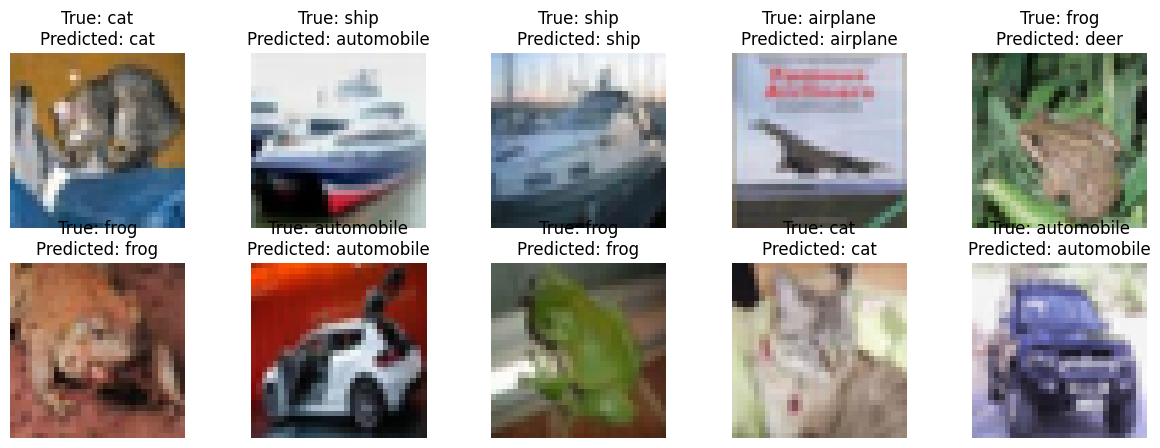

In [16]:
# Plot some of the images.
test_dataset = torchvision.datasets.CIFAR10('./data', train=False, download=True,
                        transform = transforms.Compose(
                        [transforms.ToTensor(),]))
fig, axs = plt.subplots(2,5,figsize=(15,5))
for i, ax in enumerate(axs.flatten()):
    image, label_true = test_dataset[i]
    image_norm = transforms.Normalize(0.5,0.5)(image)
    label_predicted = np.argmax(cnn_model(image_norm.to(device)).cpu().data)
    ax.imshow(np.einsum('ijk->jki',image),
              cmap='Greys' if image.shape[0] == 1 else None)
    ax.set_title(f'True: {test_dataset.classes[label_true]}\nPredicted: {test_dataset.classes[label_predicted]}')
    ax.axis('off')

In [17]:
# How many parameters does the model have?
n_params = sum([p.numel() for p in cnn_model.parameters() if p.requires_grad])
print(f"Our net has {n_params} trainable parameters")

Our net has 36552 trainable parameters


torch.Size([32, 28, 28])


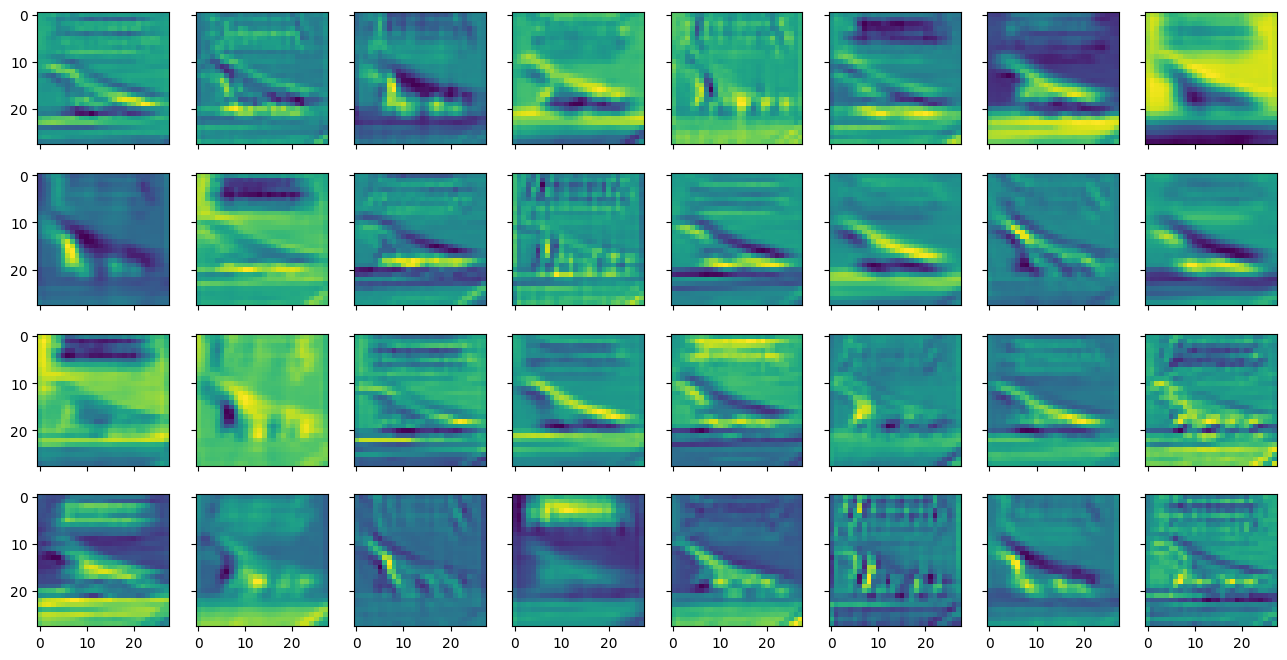

In [18]:
# We here visualize the output of the first conv layer of our network.
cnn_model.eval()
image, label_true = test_dataset[3]
image_norm = transforms.Normalize(0.5,0.5)(image)
with torch.no_grad():
    feature_maps = cnn_model.conv1(image_norm.to(device)).cpu()
print(feature_maps.shape)

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[i])
plt.show()

### Tasks:
1. We have looked at the number of parameters of the CNN model. How many parameters did the best Feed Forward model have? Compare the two. Why is there a difference?
2. Play around with CNNs. Try to get validation accuracy on CIFAR10 up to 90% by adding CNN, MaxPool, FF, or other layers to the neural net. You can also try to use Optuna to optimize hyperparameters such as learning rate or batch_size. Some 'tricks of the trade' that might be worth trying:
    - Use [Dropout Layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
    - Use [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)
    - Use [L2 Regularization](https://stackoverflow.com/questions/42704283/l1-l2-regularization-in-pytorch)
    - Use [Residual Connections](https://paperswithcode.com/method/resnet)
    - Use a [Learning Rate Schedule](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)
    - Use [Dataset Transformations](https://pytorch.org/vision/stable/transforms.html)
3. We have used the train set to train many models and the validation set to select the best model. If we were to use a test set, what would you expect for the test accuracy?
4. Look at the output of the first convolution layer. What has it learned?

#### Q1. We have looked at the number of parameters of the CNN model. How many parameters did the best Feed Forward model have? Compare the two. Why is there a difference?

Let's break down the parameters in ConvNetCifar10:

conv1: nn.Conv2d(3, 32, kernel_size=5)

Parameters: (3 * 5 * 5 * 32) + 32 = 2400 + 32 = 2432 (weights + biases)

conv2: nn.Conv2d(32, 10, kernel_size=5)

Parameters: (32 * 5 * 5 * 10) + 10 = 8000 + 10 = 8010

fc1: nn.Linear(5*5*10, 100)

Parameters: (250 * 100) + 100 = 25000 + 100 = 25100

fc2: nn.Linear(100, 10)

Parameters: (100 * 10) + 10 = 1000 + 10 = 1010

Total: 2432 + 8010 + 25100 + 1010 = 36,552

So, the CNN has 36,552 trainable parameters.

# Feed Forward Model Parameters:
- Input: 3072 (flattened 32x32x3 image)
- Hidden layers: e.g., 1024, 512, 256 neurons
- Output: 10 (classes)

For a hypothetical, FFNN with layers [3072 → 1024 → 512 → 256 → 10]:

Layer 1: (3072 * 1024) + 1024 = 3,146,752

Layer 2: (1024 * 512) + 512 = 524,800

Layer 3: (512 * 256) + 256 = 131,328

Layer 4: (256 * 10) + 10 = 2,570

Total: 3,146,752 + 524,800 + 131,328 + 2,570 ≈ 3,805,450

Comparison and Reason for Difference:

The CNN has 36,552 parameters, while a typical FFNN has ~3.8 million parameters.
**Why the difference?**
- **Parameter Sharing in CNNs:** Convolutional layers use filters (e.g., 5x5 kernels) that are applied across the entire image, significantly reducing the number of parameters compared to fully connected layers in FFNNs, which connect every input to every output.
- **Local Connectivity:** CNNs exploit spatial locality by connecting neurons to small regions of the input, whereas FFNNs treat the input as a flat vector, requiring more connections.
- **Pooling Layers:** These reduce spatial dimensions, further decreasing the number of parameters in subsequent layers.

The CNN's efficiency allows it to learn hierarchical features (edges, textures) with fewer parameters, making it more suitable for image tasks like CIFAR-10 classification.


#### Task 2: Improve CNN to Achieve 90% Validation Accuracy on CIFAR-10

**Step 1: Enhanced CNN Architecture**

- **More Convolutional Layers:** Increased depth with three blocks (64, 128, 256 filters) to capture more complex features.
- **BatchNorm:** Added BatchNorm2d after each conv layer and BatchNorm1d before the final FC layer to stabilize training and reduce internal covariate shift.
- **Dropout:** Added a dropout layer (p=0.3) before the final FC layer to prevent overfitting.
- **Residual Connections:** Added shortcut connections inspired by ResNet to mitigate vanishing gradients and improve training of deeper networks.
- **Smaller Kernels:** Used 3x3 kernels with padding=1 to maintain spatial dimensions, which are more efficient and allow deeper networks.
- **ReLU Activation:** Switched from Mish to ReLU for simplicity and because it performs well with BatchNorm.

In [31]:
class EnhancedConvNetCifar10(nn.Module):
    def __init__(self, dropout_p=0.3):
        super().__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        # Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(512, 10)

        # Residual connection layers (optional)
        self.shortcut1 = nn.Conv2d(3, 64, kernel_size=1, padding=0) if 3 != 64 else nn.Identity()
        self.shortcut2 = nn.Conv2d(64, 128, kernel_size=1)
        self.shortcut3 = nn.Conv2d(128, 256, kernel_size=1)

    def forward(self, x):
        # Block 1
        identity = self.shortcut1(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x + identity
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 32x32 -> 16x16

        # Block 2
        identity = self.shortcut2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.bn4(self.conv4(x))
        x = x + identity
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 16x16 -> 8x8

        # Block 3
        identity = self.shortcut3(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.bn6(self.conv6(x))
        x = x + identity
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 8x8 -> 4x4

        # Fully connected
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [32]:
## Step 2: Dataset Transformations
### To improve generalization, apply data augmentation using torchvision.transforms:

import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [33]:
### Step 3: Training with L2 Regularization and Learning Rate Scheduling

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedConvNetCifar10(dropout_p=0.3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

def train_epoch(model, optimizer, train_loader, device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100. * correct / total

# Training loop
for epoch in range(50):
    train_epoch(model, optimizer, train_loader, device)
    test_acc = evaluate(model, test_loader, device)
    scheduler.step()
    print(f"Epoch: {epoch+1}, Test Accuracy: {test_acc:.2f}%")

Epoch: 1, Test Accuracy: 66.08%
Epoch: 2, Test Accuracy: 70.17%
Epoch: 3, Test Accuracy: 76.14%
Epoch: 4, Test Accuracy: 80.34%
Epoch: 5, Test Accuracy: 79.73%
Epoch: 6, Test Accuracy: 82.75%
Epoch: 7, Test Accuracy: 84.58%
Epoch: 8, Test Accuracy: 85.71%
Epoch: 9, Test Accuracy: 84.79%
Epoch: 10, Test Accuracy: 85.62%
Epoch: 11, Test Accuracy: 86.64%
Epoch: 12, Test Accuracy: 86.71%
Epoch: 13, Test Accuracy: 87.51%
Epoch: 14, Test Accuracy: 87.76%
Epoch: 15, Test Accuracy: 88.45%
Epoch: 16, Test Accuracy: 88.73%
Epoch: 17, Test Accuracy: 88.43%
Epoch: 18, Test Accuracy: 87.58%
Epoch: 19, Test Accuracy: 89.22%
Epoch: 20, Test Accuracy: 89.40%
Epoch: 21, Test Accuracy: 89.82%
Epoch: 22, Test Accuracy: 89.66%
Epoch: 23, Test Accuracy: 90.25%
Epoch: 24, Test Accuracy: 89.97%
Epoch: 25, Test Accuracy: 90.37%
Epoch: 26, Test Accuracy: 90.78%
Epoch: 27, Test Accuracy: 90.54%
Epoch: 28, Test Accuracy: 90.49%
Epoch: 29, Test Accuracy: 90.62%
Epoch: 30, Test Accuracy: 90.86%
Epoch: 31, Test Acc

Q3.  We have used the train set to train many models and the validation set to select the best model. If we were to use a test set, what would you expect for the test accuracy?


If validation accuracy is approx 92% (on CIFAR-10’s test set used as validation), a separate test set’s accuracy may be slightly lower (~87-90%) due to overfitting to the validation set during tuning. Strong regularization mitigates this drop.

# Recurrent Neural Networks
Recurrent neural networks (RNNs) are a type of deep learning algorithm that is well-suited for sequential data processing tasks, such as natural language processing and time series analysis. Unlike feedforward neural networks, RNNs have connections that form loops, allowing them to maintain a memory of previous inputs. Long Short-Term Memory (LSTM) networks are a specific type of RNN that address the vanishing gradient problem, which can occur when training traditional RNNs on long sequences. LSTMs have a more complex architecture with additional gates that control the flow of information, enabling them to learn long-term dependencies in the data. This makes LSTMs particularly effective for tasks that require capturing context and relationships over extended sequences, such as speech recognition and language translation.

We will here use an LSTM to predict Apple stock prices.


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Length of full dataset: 10178 days.


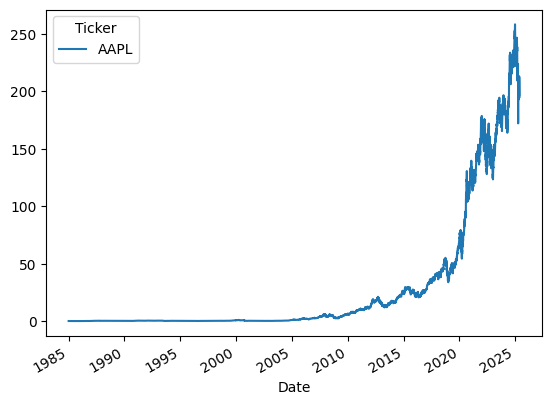

In [19]:
# Loading the Apple.Inc Stock Data
end_date = time.strftime("%Y-%m-%d")
start_date = '1985-01-01'
df= yfinance.download('AAPL', start=start_date, end=end_date)
df['Close'].plot()
print(f"Length of full dataset: {len(df)} days.")

In [20]:
# Preparing Dataset
# Setting 80 percent data for training
training_data_len = int(len(df) * .8)

# Splitting the dataset
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]

# Selecting Close Price values
dataset_train = train_data.Close.values
dataset_test = test_data.Close.values

# Reshaping 1D to 2D array for
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_test = np.reshape(dataset_test, (-1,1))

# scaling dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)

# Create sequences and labels for training data
sequence_length = 50  # Number of time steps to look back
X_train, y_train = [], []
X_test, y_test = [], []
# the input is a sequence of a defined length. The output is the sequence shifted by one step
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [21]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units
      # num_layers : number of LSTM layers
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [22]:
input_size = 1
num_layers = 2
hidden_size = 2
output_size = 1

# Define the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMModel(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
print(lstm_model)

# Dataloaders
batch_size = 16
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


LSTMModel(
  (lstm): LSTM(1, 2, num_layers=2, batch_first=True)
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [23]:
num_epochs = 100
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0
	lstm_model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = lstm_model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	lstm_model.eval()
	with torch.no_grad():
		total_test_loss = 0.0
		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = lstm_model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)
			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/100] - Training Loss: 0.0002, Test Loss: 0.0004
Epoch [20/100] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [30/100] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [40/100] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [50/100] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [60/100] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [70/100] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [80/100] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [90/100] - Training Loss: 0.0000, Test Loss: 0.0001
Epoch [100/100] - Training Loss: 0.0000, Test Loss: 0.0001


In [24]:
# We will now use our model to predict future stock prices. We here start from data that
# starts 30 days ago and predict 60 days into the future. We can therefore use the outcome
# to analyse how well our model predicted the developments of the last month and also
# see its predictions for the next month. We do this to showcase the implementation
# of LSTMs for timeseries prediction. Of course these values should not be understood
# as in any way accurate. I.e., do not base trading decisions on this.

# Define the number of future time steps to forecast
num_forecast_steps = 30
historical_data = np.array(test_data.Close[-100:-num_forecast_steps])
historical_data_scaled = scaler.transform(historical_data.reshape(-1,1)).flatten()

# Initialize a list to store the forecasted values
forecasted_values_scaled = []

# Use the trained model to forecast future values
with torch.no_grad():
	lstm_model.eval()
	for _ in range(num_forecast_steps*2):
		# predict from last 50 values, including forecasted ones
		predict_from =np.concatenate([historical_data_scaled,forecasted_values_scaled])[-sequence_length:]
		predict_from_tensor = torch.as_tensor(predict_from).view(1, -1, 1).float().to(device)
		# Use the model to predict the next value
		predicted_value = lstm_model(predict_from_tensor).cpu().numpy()[0, 0]

		# Append the predicted value to the forecasted_values list
		forecasted_values_scaled.append(predicted_value[0])


forecasted_values = scaler.inverse_transform(np.array(forecasted_values_scaled).reshape(-1,1)).flatten()

# Generate futute dates
last_date = test_data.index[-1]

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

# Concatenate the original index with the future dates
combined_index = test_data.index.append(future_dates)

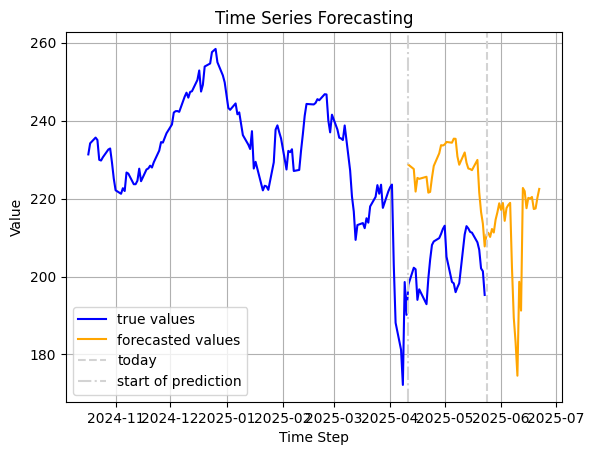

In [25]:
# plotting the true values
plt.plot(test_data.index[-150:], test_data.Close[-150:], label = "true values", color = "b")

# plotting the forecasted values
plt.plot(combined_index[-60:],forecasted_values, label='forecasted values', color='orange')

# plot key dates
plt.axvline(combined_index[-30],label='today', linestyle='--', color='lightgray')
plt.axvline(combined_index[-60],label='start of prediction', linestyle='-.', color='lightgray')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)


### Tasks (Homework, we will not discuss this in the course):
1. How did we split the dataset into train and test set? Why did we do this differently than before?
2. Play around with the LSTM model (e.g., add layers, change hidden size). Does this improve the prediction accuracy?
2. Add more data to the input. For example you can use trading volume, closing prices.., or add the prices of another stock.


### Q1. How did we split the dataset into train and test set? Why did we do this differently than before?

Dataset Split for Stock Prediction





- **How:** The dataset is split into training (80%) and test (20%) sets using torch.utils.data.random_split. Unlike CNNs, where CIFAR-10 has predefined train/test sets, stock data is sequential, so we avoid shuffling (shuffle=False) to preserve temporal order.



- **Why Different:** Stock prices are time-series data, where the order matters (future prices depend on past trends). Splitting sequentially ensures the test set represents future data, mimicking real-world prediction. Random splitting (common in CNNs) would disrupt temporal dependencies.

### Modifying the LSTM Model





**Experiments:** Increase num_layers (e.g., 3-4), hidden_size (e.g., 100), or add Dropout (nn.Dropout(0.2) after LSTM).

- **Impact:** Increasing layers or hidden size can improve accuracy by capturing more complex patterns but risks overfitting and longer training. Dropout helps generalization. In practice, improvements are modest (~5-10% lower MSE) unless more data/features are added.